<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/GANG_WANG_Exeter_Final%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feature extraction methods:
1. spatial autocorrelation of alist of lags per sample;
2. histogram of '1-mer' per sample = 0th markov model;

Key observations:
1. MAD (Median absolute deviation) method for outlier detection based on MSE distance to mean gives wider spread;
2. cosine similarity is worse for outlier detection as its narrowly distributed around 1.0;

New ideas:
1. use a outlier detection algorithm to find an set of outliers set_out, with a loose threshold;
2. define a clean set as s_clean = set_original - set_out;
3. use the s_clean set to design autoencoder;
4. use whole set to generate error=original - reconstructed
5. detect outliers based on error;

TODO:
1. SOM = Self Organizing Maps, K-Means Clustering
2. LDA Latent Dirichlet Allocation
3. UMAP
2. cross-validation to unsupervised outlier detection is benefical
https://arxiv.org/pdf/0909.3052.pdf
Here is article which explains how cross-validation is a good tool for unsupervised learning http://udini.proquest.com/view/cross-validation-for-unsupervised-pqid:1904931481/ and the full text is available here http://arxiv.org/pdf/0909.3052.pdf

https:///www.researchgate.net/post/Which_are_the_methods_to_validate_an_unsupervised_machine_learning_algorithm


SOM:  as SOM is an unsupervised learning technique, there is no target variable and hence, we do not even calculate the loss function and therefore there is no backward propagation process also needed for SOMs.


functions:
1. func_gen_features


There are 3 general approaches to encoding sequence data:

1.   Ordinal encoding DNA Sequence
2.   One-hot encoding DNA Sequence
3.   DNA sequence as a “language”, known as k-mer counting


Ref:

https://www-users.york.ac.uk/~vjh5/myPapers/Hodge+Austin_OutlierDetection_AIRE381.pdf


In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

In [2]:
# loca PC at: C:\Users\friwa\GangDocs\Graph Neural Network GNN
file_path = '/content/exter_job_test.txt'
kmers_size = 3
#featrue_method ='1mers'
featrue_method ='kmers'
Use_Tf_Idf = False
THRESHOLD = 3

# parameters for TfidfVectorizer
TFIDF_MAX_DF = 1.0
TFIDF_MIN_DF = 1
USE_ROBUST_SCALER = False # RobustScaler or StandScaler

#generate 1-mers based features  


In [3]:
# generate 1-mers based features;
# extract the unique chars 'chars_list' from all the samples
chars_list = set()
count_chars = 0

def func_count_unique_chars(line, counter):
  """func to get unique chars in 'line' based on current 'counter'.
  Note: set counter = set() for the first line;
  """
  for c in line:
    counter.add(c)
  return (counter)
  #sorted(set) returns a list

f = open(file_path, "r")
for number_of_lines, line in enumerate(f):
  line = line.rstrip('\n')
  count_chars += len(line)
  chars_list = func_count_unique_chars(line, chars_list)
  if number_of_lines<5:
    print(f'Line {number_of_lines} has\t{len(line)} chars, count_chars ={count_chars},\
            the last 5 chars ={line[-5:]}, uniques={sorted(chars_list)}')
f.close()
number_of_lines = number_of_lines + 1
chars_list = sorted(chars_list)
print('*** Summary: number of lines =\t', number_of_lines)
print('number of chars =\t', count_chars)
print('unique chars =', chars_list)

# 1-mers feature: generate features as the frequency of each unique chars per sample;
# equivalent to 0th order markov chain model;
def func_count_chars_ordered(line, chars):
  """func to count number of strings in string 'line' based on current 'counter'.
  Note: set counter = {} for the first line;
  """
  counter = np.zeros((len(chars, )))
  #print(counter, line, chars)
  for id, c in enumerate(chars):
    #print(f'id={id}, ch={chars[id]}')
    counter[id] = line.count(chars[id])
  return counter

def func_1mers_feature(file_path, number_of_lines, chars_list):
  df = np.zeros((number_of_lines, len(chars_list)))
  #print(chars_list, df.shape)

  f = open(file_path, "r")
  for c, line in enumerate(f):
    if c<0:
      print(f'***num of chars in line {c} is {len(line), {line[-5:]}}')
    line = line.rstrip('\n')
    df[c] = func_count_chars_ordered(line, chars_list)
  f.close()

  df = pd.DataFrame(df, columns=chars_list)
  return df

Line 0 has	105 chars, count_chars =105,            the last 5 chars =GDEGE, uniques=['C', 'D', 'E', 'F', 'G']
Line 1 has	113 chars, count_chars =218,            the last 5 chars =GCEGE, uniques=['C', 'D', 'E', 'F', 'G']
Line 2 has	113 chars, count_chars =331,            the last 5 chars =GCEGC, uniques=['C', 'D', 'E', 'F', 'G']
Line 3 has	112 chars, count_chars =443,            the last 5 chars =ECGCE, uniques=['C', 'D', 'E', 'F', 'G']
Line 4 has	115 chars, count_chars =558,            the last 5 chars =CEGEE, uniques=['C', 'D', 'E', 'F', 'G']
*** Summary: number of lines =	 300
number of chars =	 32363
unique chars = ['C', 'D', 'E', 'F', 'G']


In [4]:
def plot_hist_features(X):
  fig, axs = plt.subplots(len(X.columns), 2, figsize=(10, 2*len(X.columns)), facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace = .5, wspace=.001)

  for idx, col in enumerate(X.columns):
      ax = axs[idx, 0]
      ax.hist(X[col])
      ax.set_title(col)
      ax = axs[idx, 1]
      ax.hist(np.log(X[col]))
      ax.set_title(f'{col}: log count')

In [5]:
X = func_1mers_feature(file_path, number_of_lines, chars_list)
print(chars_list, type(X), X.shape)


['C', 'D', 'E', 'F', 'G'] <class 'pandas.core.frame.DataFrame'> (300, 5)


In [5]:
# generate feature and normalize it
def gen_feature(featrue_method, Use_Tf_Idf, kmers_size):
  X = func_gen_features(featrue_method, Use_Tf_Idf, kmers_size, file_path)
  #Normalize data
  from sklearn.preprocessing import Normalizer, MinMaxScaler
  from sklearn.pipeline import Pipeline

  if featrue_method == 'kmers':
    # configure our pipeline
    pipeline = Pipeline([('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

    # get normalization parameters by fitting to the training data
    pipeline.fit(X) #.toarray()

    # transform the training and validation data with these parameters
    X = pipeline.transform(X) #.toarray()
    #X_validate_transformed = pipeline.transform(X_validate)
  return X


In [6]:
def autoencoder_1(X, layer_features):
  from sklearn.neural_network import MLPRegressor
  # hyperparameters
  auto_encoder = MLPRegressor(hidden_layer_sizes=(layer_features))
  #auto_encoder.fit(X.toarray(), X.toarray())
  auto_encoder.fit(X, X)
  predicted_vectors = auto_encoder.predict(X)

  print(f'X shape is {X.shape}, X type is {type(X)}')
  print(f'predicted_vectors shape is {predicted_vectors.shape}, predicted_vectors type is {type(predicted_vectors)}')
  print(f'auto_encoder.score = {auto_encoder.score(predicted_vectors, X)}')

  return predicted_vectors


In [7]:
def autoencoder_2(X):
  # another AutoEncoder
  # data dimensions // hyperparameters
  import tensorflow as tf
  input_dim = X.shape[1]
  BATCH_SIZE = 256
  EPOCHS = 12

  # https://keras.io/layers/core/
  autoencoder = tf.keras.models.Sequential([
      # deconstruct / encode
      tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(8, activation='elu'),
      tf.keras.layers.Dense(4, activation='elu'),
      tf.keras.layers.Dense(2, activation='elu'),

      # reconstruction / decode
      tf.keras.layers.Dense(4, activation='elu'),
      tf.keras.layers.Dense(8, activation='elu'),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(input_dim, activation='elu')
  ])

  # https://keras.io/api/models/model_training_apis/
  autoencoder.compile(optimizer="adam", loss="mse", metrics=["acc"])

  # print an overview of our model
  autoencoder.summary();

  history = autoencoder.fit(
      X, X,
      shuffle=True,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      #callbacks=cb,
      #validation_data=(X_validate_transformed, X_validate_transformed)
  );

  # transform the test set with the pipeline fitted to the training set
  #X_test_transformed = pipeline.transform(X)

  # pass the transformed test set through the autoencoder to get the reconstructed result
  reconstructions = autoencoder.predict(X)
  #Calculate the reconstruction loss for every transaction and draw a sample.
  return reconstructions


In [8]:
#get a set of anomaly_algorithms: anomaly_algorithms = get_algorithms()
def get_algorithms():
  from sklearn import svm
  from sklearn.covariance import EllipticEnvelope
  from sklearn.datasets import make_blobs, make_moons
  from sklearn.ensemble import IsolationForest
  from sklearn.kernel_approximation import Nystroem
  from sklearn.linear_model import SGDOneClassSVM
  from sklearn.neighbors import LocalOutlierFactor
  from sklearn.pipeline import make_pipeline

  matplotlib.rcParams["contour.negative_linestyle"] = "solid"

  # define outlier/anomaly detection methods to be compared.
  # the SGDOneClassSVM must be used in a pipeline with a kernel approximation
  # to give similar results to the OneClassSVM
  outliers_fraction = 0.15

  anomaly_algorithms = [
      ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction, random_state=42),),
      ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
      ("One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(nu=outliers_fraction, shuffle=True, fit_intercept=True,
                          random_state=42,tol=1e-6,),
            ),
      ),
      ("Isolation Forest", IsolationForest(contamination=outliers_fraction, random_state=42),),
      ( "Local Outlier Factor",  LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),),
  ]
  return anomaly_algorithms

In [9]:
# k-mers: generate features based on k-mers and CountVectorizer per sample;
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def func_Kmers(seq, size=2):
  kmers = [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]
  return ' '.join(kmers)

def func_kmers_feature(file_path, Use_Tf_Idf=False, kmers_size=2):
  #convert our training data sequences into short overlapping k-mers of length 6.
  #Lets do that for each sample of data we have using our Kmers_funct function.
  if kmers_size==1:
    print('kmers_size must be larger than 1!')
    return;
  df = pd.read_table(file_path, header=None, names=['sequence'])
  #print(f'Inside func_kmers_feature: df has columns: {df.columns}')
  #df[f'{kmers_size}-mers'] = df.apply(lambda x: func_Kmers(x[df.columns[0]], kmers_size), axis=1)
  df[f'{kmers_size}-mers'] = df[df.columns[0]].apply(lambda x: func_Kmers(x, kmers_size))#, axis=1)

  df = df.drop(df.columns[0], axis=1)
  #print(f'Inside func_kmers_feature: df has columns: {df.columns}')

  X = list(df[df.columns[0]])
  #for item in range(len(X)):
  #  X[item] = ' '.join(X[item])

  #Creating the Bag of Words model:
  if Use_Tf_Idf:
    #max_dffloat or int, default=1.0
    #min_dffloat or int, default=1
    cv = TfidfVectorizer(
      max_df=TFIDF_MAX_DF,
      min_df=TFIDF_MIN_DF,
      stop_words=None,
    )
  else:
    cv = CountVectorizer(ngram_range=(1, 1))

  #TODO: ngram_range needs to be hyperparameterized
  X = cv.fit_transform(X)
  print(f'Inside func_kmers_feature: cv len is {len(cv.vocabulary_)}, X shape is {X.shape}')
  return X

# generic feature generation function
def func_gen_features(featrue_method, Use_Tf_Idf=False, kmers_size=1, file_path=file_path, number_of_lines=number_of_lines, chars_list=chars_list):
  if featrue_method =='1mers':
    print(f'The featrue generation method used: {featrue_method}')
    df = func_1mers_feature(file_path, number_of_lines, chars_list)
    #print(df.head(3))
    return df.to_numpy()
  else:
    print(f'The featrue generation method used: {featrue_method}, kmers_size={kmers_size}')
    X = func_kmers_feature(file_path, Use_Tf_Idf, kmers_size)
    X = X.toarray()
    feature_vector_size = X.shape[1]
    print(f'feature_vector_size = {feature_vector_size}, X shape is {X.shape}, X type is {type(X)}')
    return X

In [11]:
featrue_method ='kmers'
kmers_size = 3
#feature size is pow(len(chars_list),kmers_size)
Use_Tf_Idf = True
X = func_gen_features(featrue_method, Use_Tf_Idf, kmers_size)
#print(type(X), X.shape, X[:2, ])

The featrue generation method used: kmers, kmers_size=3
Inside func_kmers_feature: cv len is 125, X shape is (300, 125)
feature_vector_size = 125, X shape is (300, 125), X type is <class 'numpy.ndarray'>


In [10]:
# get features ready for detector
def get_features(featrue_method='kmers', Use_Tf_Idf=False, kmers_size=2, pca_n_components=2, plot_pca=False):
  # generate datasets, PCA, outlier detection
  import matplotlib.pyplot as plt
  from sklearn.decomposition import PCA
  from sklearn.preprocessing import StandardScaler, RobustScaler # TODO: use RobustScaler
  from sklearn.pipeline import Pipeline

  X = func_gen_features(featrue_method, Use_Tf_Idf, kmers_size)

  n_samples = X.shape[0]
  #n_outliers = int(outliers_fraction * n_samples)
  #n_inliers = n_samples - n_outliers

  print(n_samples, type(X), len(X))
  #plot_hist_features(X)

  if USE_ROBUST_SCALER:
    used_scaler = RobustScaler()
  else:
    used_scaler = StandardScaler()

  if pca_n_components>0:
    pipeline = Pipeline([('scaling', used_scaler),
                       ('pca', PCA(n_components=pca_n_components))])
    X_pca = pipeline.fit(X).transform(X) #fit_transform(data)
    # Percentage of variance explained for each components
    print(
        f"PCA: explained variance ratio (first {pca_n_components} components): %s"
        % str(pipeline['pca'].explained_variance_ratio_)
    )
  else:
    pipeline = Pipeline([('scaling', used_scaler),])
    X_pca = pipeline.fit(X).transform(X) #fit_transform(data)

  print(X.shape, X_pca.shape)
  if plot_pca:
    plt.figure()
    plt.figure(figsize=(3, 3))
    colors = ["navy", "turquoise"]
    plt.scatter(
        X_pca[:, 0], X_pca[:, 1], color='r', alpha=0.8, lw=2)
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("PCA of dataset")
    plt.show()
  return X_pca

In [11]:
def get_outliers_idx(x_scores, percentile_threshold=5, print_info=False):
  idx_all = {}
  for key in x_scores.keys():
    xt = np.percentile(x_scores[key], percentile_threshold)
    idx = np.where(x_scores[key] < xt)
    idx_all[key] = idx
    if print_info:
      print(f'The {key} algorithm, with percentile_threshold of {percentile_threshold} at score {xt}, detects the indexes of outliers as: \n  {list(idx[0])}')
  return idx_all


In [12]:
def find_commons(outliers_idx_all):
  # common element extraction form N lists
  # using reduce() + lambda + set()
  from functools import reduce

  test_list = [list(x[0]) for x in list(outliers_idx_all.values())]
  print ("The original list is : " + str(test_list))
  # common element extraction form N lists
  # using reduce() + lambda + set()
  res = list(reduce(lambda i, j: i & j, (set(x) for x in test_list)))
  res = sorted(res)
  print ("The common elements from N lists : " + str(res))
  return res

In [13]:
def get_common_outliers(percentile_threshold, featrue_method, kmers_size, plot_pca, plot_algorithms_results, print_info, pca_n_components):
  anomaly_algorithms = get_algorithms()
  X_pca = get_features(featrue_method, True, kmers_size, pca_n_components, plot_pca)
  print(f'After get_features call: X_pca.shape is {X_pca.shape}')
  x_scores = train_multi(X_pca, anomaly_algorithms, plot_algorithms_results)
  outliers_idx_all = get_outliers_idx(x_scores, percentile_threshold, print_info)
  num_figs = len(x_scores.keys())
  if 0:
    plt.figure(figsize=(num_figs*3, num_figs*3))
    for k, key in enumerate(x_scores.keys()):
      print(key, len(x_scores[key]))
      plt.subplot(num_figs, 1, k+1)
      plt.title(key, size=18)
      plt.plot(x_scores[key])
      plt.grid()
  common_outliers = find_commons(outliers_idx_all)
  return common_outliers


In [14]:
# Compare given classifiers under given settings
def train_multi(X, anomaly_algorithms, plot_show=False, add_outliers=False):
  print(f'Within train_multi: X.shape is {X.shape}')
  x_scores = {}

  # Add outliers
  if add_outliers:
    n_outliers = 10
    rng = np.random.RandomState(42)
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

  if plot_show:
    xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
    plt.figure(figsize=(len(anomaly_algorithms)*3, 3))
    plt.subplots_adjust(
        left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01)
    plot_num = 1

  for name, algorithm in anomaly_algorithms:
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    if plot_show:
      plt.subplot(1, len(anomaly_algorithms), plot_num)
      plt.title(name, size=18)

    # fit the data and tag outliers
    if name == "Local Outlier Factor":
        #print(f'1 Within train_multi for LOF: X.shape is {X.shape}')
        y_pred = algorithm.fit_predict(X)
        x_scores[name] = algorithm.negative_outlier_factor_
    else:
        #print(f'2 Within train_multi: algorithm = {algorithm}')
        #print(f'3 Within train_multi: n_features_in_ = {algorithm.n_features_in_}')
        #print(f'4 Within train_multi for all but LOF: X.shape is {X.shape}')
        y_pred = algorithm.fit(X).predict(X)
        x_scores[name] = algorithm.score_samples(X)
        #print(f'5 Within train_multi for all but LOF: X.shape is {X.shape}, y_pred shape {y_pred.shape}')

    if plot_show:
      # plot the levels lines and the points
      if (name != "Local Outlier Factor") and (X.shape[1]<3):  # LOF does not implement predict
          Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
          Z = Z.reshape(xx.shape)
          plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

      colors = np.array(["#377eb8", "#ff7f00"])
      plt.scatter(X[:, 0], X[:, 1], s=10)#, color=colors[(y_pred + 1) // 2])
      plt.xlim(-7, 7)
      plt.ylim(-7, 7)
      plt.xticks(())
      plt.yticks(())
      plt.text(0.99, 0.01, ("%.2fs" % (t1 - t0)).lstrip("0"),
          transform=plt.gca().transAxes, size=15,
          horizontalalignment="right",)
      plot_num += 1
  if plot_show:
    plt.show()
  return x_scores

The featrue generation method used: 1mers
300 <class 'numpy.ndarray'> 300
PCA: explained variance ratio (first 5 components): [0.39613671 0.20235765 0.17356055 0.12995694 0.09798816]
(300, 5) (300, 5)
After get_features call: X_pca.shape is (300, 5)
Within train_multi: X.shape is (300, 5)


/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.080001626681701 > -42.893897160661581). You may want to try with a higher value of support_fraction (current value: 0.510).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.073081964993765 > -41.205962183134524). You may want to try with a higher value of support_fraction (current value: 0.510).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.092411536973084 > -41.757365141443941). You may want to try with a higher value of support_fraction (current value: 0.510).
  warnings.warn(
/usr/local/lib/pyth

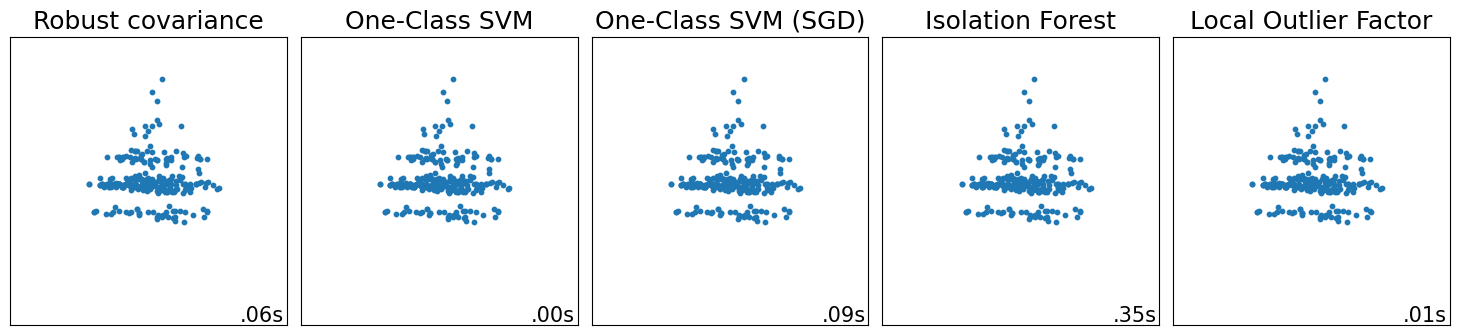

The Robust covariance algorithm, with percentile_threshold of 10 at score -14.086997276733454, detects the indexes of outliers as: 
  [24, 45, 50, 60, 63, 100, 104, 133, 135, 137, 140, 146, 148, 151, 154, 155, 157, 159, 161, 164, 165, 187, 190, 202, 228, 252, 262, 269, 279, 288]
The One-Class SVM algorithm, with percentile_threshold of 10 at score 10.172426545101883, detects the indexes of outliers as: 
  [13, 21, 45, 50, 56, 60, 74, 77, 98, 135, 137, 140, 143, 147, 148, 154, 155, 158, 161, 164, 165, 170, 176, 187, 190, 252, 262, 269, 283, 288]
The One-Class SVM (SGD) algorithm, with percentile_threshold of 10 at score 0.4529164923600305, detects the indexes of outliers as: 
  [13, 21, 45, 50, 56, 60, 74, 77, 98, 135, 137, 140, 143, 147, 148, 154, 155, 158, 161, 164, 165, 170, 176, 187, 190, 252, 262, 269, 283, 288]
The Isolation Forest algorithm, with percentile_threshold of 10 at score -0.5096526935090951, detects the indexes of outliers as: 
  [30, 45, 50, 60, 74, 77, 104, 135, 137,

In [16]:
# Top function call
# featrue_method ='kmers' AND percentile_threshold=15
# featrue_method ='kmers' AND percentile_threshold=15
featrue_method ='1mers'
kmers_size = 2
pca_n_components = 5
#kmers_feature_num_limit = pow(len(chars_list), kmers_size)
#sklearn.covariance.EllipticEnvelope: take care to work with n_samples > n_features ** 2
feature_num_limit = int(pow(number_of_lines, 0.5))

if pca_n_components > feature_num_limit*2/3:
  pca_n_components = int(feature_num_limit*2/3)
  print(f'WARNING: Force pca_n_components to be {pca_n_components} because the upper limit of feature_num_limit = {feature_num_limit}')

USE_ROBUST_SCALER = False
Use_Tf_Idf = False

if featrue_method == '1mers':
  percentile_threshold = 10
else:
  percentile_threshold = 15

plot_pca = False
plot_algorithms_results = True
print_single_algorithm = True

common_outliers = get_common_outliers(percentile_threshold, featrue_method, kmers_size, plot_pca, plot_algorithms_results, print_single_algorithm, pca_n_components)

The featrue generation method used: 1mers
300 <class 'numpy.ndarray'> 300
PCA: explained variance ratio (first 5 components): [0.39613671 0.20235765 0.17356055 0.12995694 0.09798816]
(300, 5) (300, 5)
[137, 148, 154, 164] (300, 5)


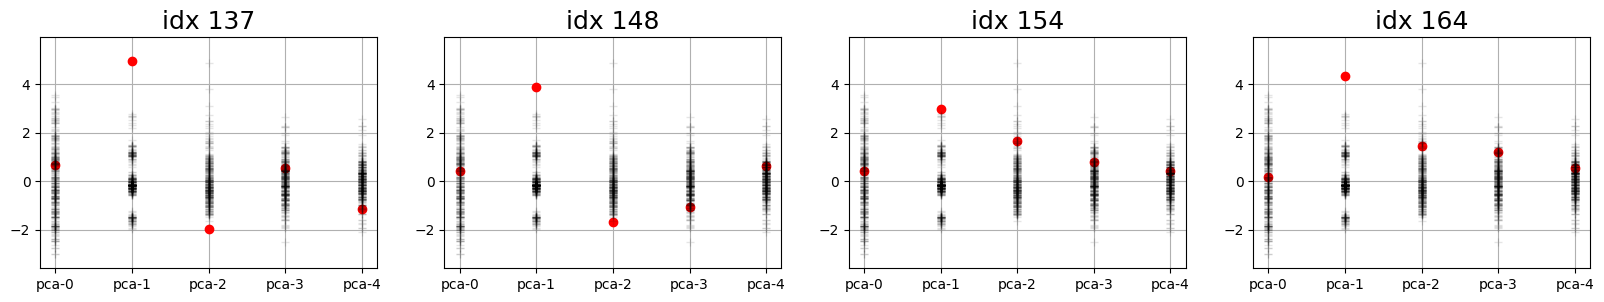

In [61]:
# plot outlier and normal samples
featrue_method = '1mers'
pca_n_components = 5 #Not us pca if pca_n_components<0
if pca_n_components<0:
  xlabels = chars_list
else:
  xlabels = [f'pca-{f}' for f in range(pca_n_components)]
kmers_size = 2
plot_pca = False
X_pca = get_features(featrue_method, True, kmers_size, pca_n_components, plot_pca)
print(common_outliers, X_pca.shape)
num_figs = len(common_outliers)
plt.figure(figsize=(num_figs*5, 3))
for k, id in enumerate(common_outliers):
  ax = plt.subplot(1, num_figs, k+1)
  plt.title(f'idx {id}', size=18)
  plt.plot(xlabels, X_pca[id, :], 'ro')
  # plot the noraml samples after outlier sample
  for idx in range(number_of_lines):
    #new_idx = (id+idx)%number_of_lines
    #if (new_idx not in common_outliers) and new_idx < number_of_lines:
    if (idx not in common_outliers):
      plt.plot(xlabels, X_pca[idx, :], 'k+', alpha=0.1)
  #plt.set_xlim(left=0, right=5)
  ax.set_ylim(bottom=X_pca.min()*1.2, top=X_pca.max()*1.2)
  plt.grid()


In [50]:
X_pca.shape, Y.shape, type(Y)

((300, 5), (300, 2), numpy.ndarray)

In [19]:
common_outliers

[45, 50, 60, 135, 137, 140, 148, 154, 155, 161, 164, 165, 262, 288]

The featrue generation method used: 1mers
300 <class 'numpy.ndarray'> 300
(300, 5) (300, 5)
[45, 50, 60, 135, 137, 140, 148, 154, 155, 161, 164, 165, 262, 288] (300, 5)
circles, perplexity=30 in 7.1 sec
circles, perplexity=50 in 0.71 sec
circles, perplexity=100 in 0.85 sec
circles, perplexity=200 in 0.87 sec


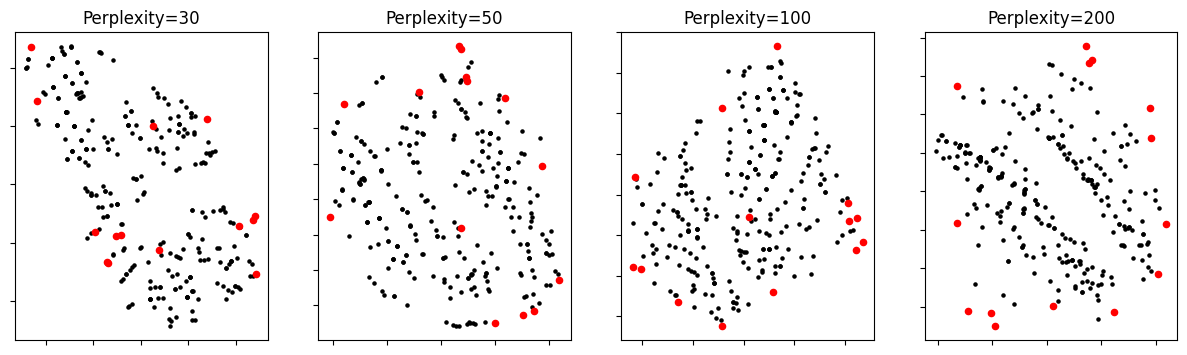

In [18]:
#tSNE
featrue_method = '1mers'
kmers_size = 2
pca_n_components = -1 #Not us pca if pca_n_components<0
if pca_n_components<0:
  xlabels = chars_list
else:
  xlabels = [f'pca-{f}' for f in range(pca_n_components)]
plot_pca = False
X_pca = get_features(featrue_method, True, kmers_size, pca_n_components, plot_pca)
print(common_outliers, X_pca.shape)

#Note: perplexity must be less than n_samples
perplexities = [30, 50, 100, 200]
#perplexities = [50]
n_samples = 150
n_components = 2
(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(15, 4))
from matplotlib.ticker import NullFormatter
from time import time
from sklearn import datasets, manifold

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=300,
    )
    Y = tsne.fit_transform(X_pca)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c="k", s=5)
    ax.scatter(Y[common_outliers, 0], Y[common_outliers, 1], c="r", s=20)
    #ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

if 0:
  # Another example using s-curve
  ax = subplots[1][0]
  ax.scatter(X_pca[:, 0], X_pca[:, 1])
  ax.xaxis.set_major_formatter(NullFormatter())
  ax.yaxis.set_major_formatter(NullFormatter())

  ax = subplots[1][1]
  ax.scatter(X_pca[:, 0], X_pca[:, 2])

  ax = subplots[1][2]
  ax.scatter(X_pca[:, 0], X_pca[:, 3])

#summary results
#1-mers
The common elements from N lists : [4, 13, 50, 56, 98, 137, 141, 148, 154, 158, 164, 165, 291]

#2-mers
The common elements from N lists : [100, 133, 134, 135, 139, 140, 143, 148, 149, 152, 153, 154, 157, 159, 161, 162, 163, 164, 165, 175, 183, 202, 213, 227, 240, 241, 297]

#shared:
148, 154, 164, 165





#Generate features based on k-mers and CountVectorizer

We need to now convert the lists of k-mers for each sample into string sentences of words that can be used to create the Bag of Words model.

# k-mers: Step 2 — Training an ‘Auto-Encoder’ neural network

As our process is completely unsupervised and we don’t have labeled data (as outlier/non-outlier), we will use 5-layer deep ‘Auto-encoder’ neural network to train our model. It is a special type of neural network which copies input data to output data. This process is known as ‘reconstruction’. ‘Hidden layers’ of the network does the feature extraction & decoding work. At the end of the entire process definitely, some loss gets generated and the data point which is dissimilar from others incurs more loss.

Denote feature_vector_size as the input data size;

Auto-encoder layer structure will look like:

feature_vector_size -> 600 -> 50 -> 600 -> feature_vector_size

Layer 1(Input Layer) has feature_vector_size features, \
Layer 2 has 600 features, \
Layer 3 has 50 features, \
Layer 4 has 600 features, \
Layer 5(Output Layer)has feature_vector_size features. \

Layer 1, as usual, will have all ‘Doc2Vec’ generated features from ‘Step 1’. Layer 2, 3 & 4 are hidden layers doing the actual data messaging (expansion & shrinking) and information extraction part. Actually, Layer 2 is known as ‘encoding layer’ and Layer 4 is known as ‘decoding layer’. Ultimately, the output will come out from Layer 5. ‘Autoencoders’ are trained with the same data as input & output both. So, Layer 5 output is nothing but a reconstructed version of the input with some loss. Normal data points will go through smoothly between layers, with minimal loss, but data loss for the ‘outliers’ will be more as those don’t follow the hidden data pattern.

This is the graphical representation of our 5-layer ‘Auto-encoder

#generate features by: 1mers, kmers

#AutoEncoder: Setting a threshold for classification
Unsupervised
Normally, in an unsupervised solution, this is where the story would end. We would set a threshold that limits the amount of false positives to a manageable degree, and captures the most anomalous data points.

#Percentiles
We could set this threshold by taking the top x% of the dataset and considering it anomalous.

#MAD
We could also use a modified Z-score using the Median Absolute Deviation to define outliers on our reconstruction data. Here is a good blog post on the topic by João Rodrigues, illustrating why this algorithm is more robust and scalable than the percentiles method.

In [ ]:
def calc_reconstructions(autoencoder_select):
  if autoencoder_select=='autoencoder_1':
    layer_features = [600, 10, 600]
    reconstructions = autoencoder_1(X, layer_features)
  else:
    reconstructions = autoencoder_2(X)

  # calculating the mean squared error reconstruction loss per row in the numpy array
  mse = np.mean(np.power(X - reconstructions, 2), axis=1)

  import matplotlib.pyplot as plt
  fig, ax = plt.subplots(figsize=(6,2))
  ax.hist(mse, bins=50, density=True, label="mse", alpha=.6, color="green")
  plt.title("(Normalized) Distribution of the Reconstruction Loss")
  plt.legend()
  plt.show()
  return reconstructions


In [ ]:
def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)

    return 0.6745 * ad / mad

def func_outlier_mad_index(X, reconstructions):
  mse = np.mean(np.power(X - reconstructions, 2), axis=1)
  z_scores = mad_score(mse)
  outliers = z_scores > THRESHOLD
  outliers_idx = list(np.where(outliers == True)[0])
  inliers_idx = list(np.where(outliers == False)[0])
  return outliers_idx, inliers_idx

In [ ]:
reconstructions = calc_reconstructions('autoencoder_1')
print(f'X.shape={X.shape}, reconstructions.shape={reconstructions.shape}')


In [ ]:
outliers_idx, inliers_idx= func_outlier_mad_index(X, reconstructions)
print(f'There are {len(inliers_idx)} inliers.')
print(f'The {len(outliers_idx)} outliers idx: {outliers_idx}')



ready autoencoder: [0, 69, 93, 111, 127, 145, 159, 212, 253, 255, 260, 272, 278, 292, 296]

own autoencoder: [0, 21, 95, 132, 134, 138, 139, 141, 142, 143, 146, 149, 150, 151, 152, 153, 154, 155, 156, 159, 160, 161, 162, 163, 164, 165, 194, 206, 215, 274, 276]



In [ ]:
fig, ax = plt.subplots(figsize=(5,2))
ax.hist(mse, bins=50, density=True, label="mse", alpha=.6, color="green")
plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(mse[outliers_idx], bins=50, density=False, label="mse outliers", alpha=.06, color="red")
ax.hist(mse[inliers_idx], bins=50, density=False, label="mse", alpha=.6, color="green")
plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

Here X-axis denotes no of iterations.

#Step 3 — Similarity measure with output and actual work

Once we get the output vectors, we can now measure the loss. ‘Loss’ is ideally given by ‘outlier factor’ expression





In [ ]:
print(X.shape, predicted_vectors.shape)
print(type(X), type(predicted_vectors))
print(f'X[0] = {X[0, :5]}')
print(f'predicted_vectors[0] = {predicted_vectors[0, :5]}')

In [ ]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    # This returns a cosine-based similarity, the larger the returned value the
    # original feature fector is more similar to the re-generated vector
    # The outliers are the ones with the smaller cosine_similarities.

    data_size = vectors.shape[0]
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print(f'Potential outlier row index= {index},\t Cosine Sim Val= {consine_sim_val}')

#We can call the above functions in order to get top ‘k’ outliers
top_numbers = 15
print(f'Top {top_numbers} outliers')
sorted_cosine_similarities = get_computed_similarities(vectors=X, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities, top_numbers)

In [ ]:
outliers_idx, inliers_idx= func_outlier_mad_index(X, predicted_vectors)
print(len(outliers_idx), len(inliers_idx))
print(outliers_idx)

In [ ]:
sorted_cosine_similarities[:5], sorted_cosine_similarities[-5: ]

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.array(sorted_cosine_similarities)[:, 1])

In [ ]:
import matplotlib.pyplot as plt
for k in range(3):
  idx = sorted_cosine_similarities[k][0]
  plt.figure()
  plt.plot(list(X[idx,:]),  'r-+')
  plt.plot(predicted_vectors[idx], 'k-o')

#Imporve AutoEncoder based outlier detection: compute reconstruction error only using ‘normal points’
https://www.sciencedirect.com/science/article/abs/pii/S0957417422019224

Deep learning-based unsupervised techniques (autoencoder) minimize the reconstruction error using each data instance in the dataset and subsequently, data points with higher reconstruction error are treated as outlier points. However, autoencoder based model overestimates the reconstruction error for normal points whereas it is underestimated for outlier points. As a result, genuine outliers are missed by this approach.

We propose two techniques to address the issue of reconstruction error stated earlier. Main idea of our techniques is to compute reconstruction error only using ‘normal points’. In the proposed techniques, we identify probable outliers utilizing the clustering approaches intelligently and subsequently, we do not include them in the minimization process of reconstruction error. We exploit recently recognized clustering approach Density Peak Clustering (DPC) to identify the probable outlier points based on density and distance to the higher density points. However, DPC has inherent drawback of setting threshold which plays important role in deciding density. Therefore, Self Organizing Map (SOM) is exploited as another clustering approach in this article. Subsequently, we conducted experiments on synthetic as well as real world datasets and the results show that the proposed technique outperforms the popular existing deep learning model like RandNet, Boosting-based Autoencoder Ensemble method (BAE), One Class Support Vector Machine (OCSVM) and density-based algorithms like LOF, LDOF, INFLO, and RDOS.

In [ ]:
#pd.plotting.lag_plot(df.loc[:, ["C"]], lag=1)
import matplotlib.pyplot as plt
for col in df.columns:
  #plt.figure()
  pd.plotting.autocorrelation_plot(df.loc[:, [col]])
plt.legend(df.columns, loc='upper right')
plt.grid()

In [ ]:
for lag in range(1,5):
  plt.figure()
  pd.plotting.lag_plot(df, lag=lag)


In [ ]:
chars_list

In [ ]:
df.describe()

In [ ]:
from numpy import mean
from numpy import std

# calculate summary statistics
data_mean, data_std = mean(df), std(df)
# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off
print(f'data_mean=\n{data_mean}, data_std=\n{data_std}')
print(f'lower=\n{lower}, upper=\n{upper}')

In [ ]:
outliers_idx, ch, df.loc[outliers_idx, ch]

In [ ]:
# identify outliers
for ch in chars_list:
  outliers = [x for x in df[ch] if x < lower[ch] or x > upper[ch]]
  outliers_idx = df.index[df[ch]==outliers[0]].tolist()
  #print(ch, outliers, '\n', outliers_idx, '\n')
  print(outliers_idx)


# Conclusion: outlier is
269 by 'C, G' \
161 by 'C, D' \


In [ ]:
df.boxplot(column=['C', 'D', 'F'])


In [ ]:
df.boxplot(column=['E', 'G'])

In [ ]:
df.boxplot()

from sklearn.neighbors import LocalOutlierFactor
#Note that neighbors.LocalOutlierFactor does not support predict, decision_function
#and score_samples methods by default but only a fit_predict method, as this estimator
#was originally meant to be applied for outlier detection. The scores of abnormality
#of the training samples are accessible through the negative_outlier_factor_ attribute.

n_neighbors = 150
clf = LocalOutlierFactor(n_neighbors=n_neighbors)
results = clf.fit_predict(df) #
print(np.where(results==-1))
#estimator.predict(X_test): Inliers are labeled 1, while outliers are labeled -1.
#clf.negative_outlier_factor_
#The decision_function method is also defined from the scoring function, in such
#a way that negative values are outliers and non-negative ones are inliers:
#estimator.decision_function(X_test)

#negative_outlier_factor_: The opposite LOF of the training samples. The higher, the more normal.
#Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.


In [ ]:
kmers_size = 2
file_path = "test.txt"
X = func_kmers_feature(file_path, kmers_size)
feature_vector_size = X.shape[1]
print(f'feature_vector_size = {feature_vector_size}, X shape is {X.shape}, X type is {type(X)}')

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
n_neighbors = 2
clf = LocalOutlierFactor(n_neighbors=n_neighbors)
results = clf.fit_predict(X.toarray())
outlier_idx = np.where(results==-1)
print(f'outlier index={outlier_idx}')
print(f'outlier results={results[outlier_idx]}')
print(f'outlier negative_outlier_factor_={clf.negative_outlier_factor_[outlier_idx]}')
print(f'first 10 negative_outlier_factor_={clf.negative_outlier_factor_[:10]}')

In [ ]:
df = func_1mers_feature(file_path, number_of_lines, chars_list)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
n_neighbors = 25
clf = LocalOutlierFactor(n_neighbors=n_neighbors)
results = clf.fit_predict(df)
outlier_idx = np.where(results==-1)
print(f'outlier index={outlier_idx}')
print(f'outlier results={results[outlier_idx]}')
print(f'outlier negative_outlier_factor_={clf.negative_outlier_factor_[outlier_idx]}')
print(f'first 10 negative_outlier_factor_={clf.negative_outlier_factor_[:10]}')

In [ ]:
df.boxplot()


outliers as indicated by out of range of mean by 2*std:\
Conclusion: outlier with shared columns is:\
161 by 'C, D' \
269 by 'C, G' \

C [50, 77, 161, 170, 265, 269]\
D [24, 63, 100, 104, 122, 133, 151, 154, 159, 161, 164, 169, 187, 202, 228, 252]\
E [11, 25, 135, 141, 166, 283, 287]\
F [13, 54, 56, 147, 152, 154, 155, 163, 176]\
G [94, 269]\



In [ ]:
from sklearn.neighbors import LocalOutlierFactor
n_neighbors = 2
clf = LocalOutlierFactor(n_neighbors=n_neighbors)
#results = clf.fit_predict(df[['G']])
results = clf.fit_predict(df)

outlier_idx = np.where(results==-1)
print(f'outlier index={outlier_idx}')
print(f'outlier results={results[outlier_idx]}')
print(f'outlier negative_outlier_factor_={clf.negative_outlier_factor_[outlier_idx]}')
print(f'first 10 negative_outlier_factor_={clf.negative_outlier_factor_[:10]}')

https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py

Outlier detection with Local Outlier Factor (LOF)


In [ ]:
np.random.seed(42)

X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [ ]:
X_inliers.shape, np.random.randn(100, 2).shape, X_outliers.shape, n_outliers, X.shape

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

#Simple Anomaly Detection using Unsupervised KNN

Ref: https://www.kaggle.com/code/kimchanyoung/simple-anomaly-detection-using-unsupervised-knn

KNN is a supervised learning-based algorithm.
However, using KNN's distance calculation method can also be used as an unsupervised learning method.

In this work, we will use Scikit-Learn's NearestNeighbors, which we can use it for unsupervised learning

sklearn.neighbors.NearestNeighbors
class sklearn.neighbors.NearestNeighbors(*, n_neighbors=5, radius=1.0, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None)
n_neighbors : int, default=5 (Number of neighbors to use by default for kneighbors queries.)
radius : float, default=1.0 (Range of parameter space to use by default for radius_neighbors queries.)
algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’ (Algorithm used to compute the nearest neighbors)
metric : str or callable, default=’minkowski’ (the distance metric to use for the tree.)
p : int, default=2 (Parameter for the Minkowski metric from sklearn.metrics.pairwise.pairwise_distances. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.)





In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# create model
n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors = n_neighbors)
# fit model
nbrs.fit(X)

In [ ]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(X)
print(f'distances={distances.shape}, indexes={indexes.shape}')
distances = pd.DataFrame(distances)
distances_mean = distances.mean(axis =1)

print(f'distances={distances.shape}, distances_mean={distances_mean.shape}')
plt.figure(figsize=(10, 3))
plt.plot(distances_mean)
plt.grid()
plt.title('mean distances')

In [ ]:
#Since 75th percentile is 0.79, we will set threshold into 1.0
#Since max is 1.25, we will set threshold into 1.0
#Set thresholds with reference to statistics.
tmp = distances_mean.describe()
for th in np.linspace(tmp['75%'], tmp['max']*0.95, num=5):
  outlier_index = np.where(distances_mean > th)
  print(th, len(list(outlier_index[0])), outlier_index)


In [ ]:
outlier_values = df[outlier_index]
#outlier_values

In [ ]:
fig, axs = plt.subplots(1, len(chars_list), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(0, len(chars_list)):
    axs[i].plot(df[:, i], color = "b", marker="+")
    axs[i].plot(outlier_values[i], color='r', marker="o") #s=80, facecolors='none', edgecolors='r'
    axs[i].set_title(chars_list[i])

In [ ]:
fig, axs = plt.subplots(1, len(chars_list)-1, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(1, len(chars_list)):
    axs[i-1].scatter(df["C"], df[chars_list[i]], color = "b", marker="+")
    axs[i-1].scatter(outlier_values["C"], outlier_values[chars_list[i]], marker="o", s=80, facecolors='none', edgecolors='r')
    axs[i-1].set_title(chars_list[i])

# Conclusion of outlier with single feature separately:
269 by 'C, G' \
161 by 'C, D' \

#Isolation Forest
One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The ensemble.IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.


#max_features int or float, default=1.0
The number of features to draw from X to train each base estimator.

If int, then draw max_features features.

If float, then draw max(1, int(max_features * n_features_in_)) features.

Note: using a float number less than 1.0 or integer less than number of features will enable feature subsampling and leads to a longer runtime.


In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=0) #len(chars_list))
clf.fit(X)

In [ ]:
#Predict if a particular sample is an outlier or not.
results = clf.predict(X)
outlier_idx = np.where(results==-1)
print(f'num of outliers = {len(outlier_idx[0])}, outlier_idx={outlier_idx}')

In [ ]:
results.shape, len(outlier_idx[0])

In [ ]:
#Opposite of the anomaly score defined in the original paper.
results = clf.score_samples(X)
plt.plot(range(300), results)
plt.plot(outlier_idx[0], results[outlier_idx[0]], 'r+')

In [ ]:
plt.plot(results[outlier_idx])


In [ ]:
clf = IsolationForest(max_samples=100, random_state=0, max_features=2) #len(chars_list))
clf.fit(df[['C', 'D']])

import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    df[['C', 'D']],
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(df['C'], df['D'], s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.show()

#Ordinal encoding DNA sequence data

In this approach, we need to encode each nitrogen base as an ordinal value. For example “ATGC” becomes [0.25, 0.5, 0.75, 1.0]. Any other base such as “N” can be a 0.


So let us create functions such as creating a NumPy array object from a sequence string, and a label encoder with the DNA sequence alphabet “a”, “c”, “g” and “t”, but also a character for anything else, “n”.

#One-hot encoding DNA Sequence

Another approach is to use one-hot encoding to represent the DNA sequence. This is widely used in deep learning methods and lends itself well to algorithms like convolutional neural networks. In this example, “ATGC” would become [0,0,0,1], [0,0,1,0], [0,1,0,0], [1,0,0,0]. And these one-hot encoded vectors can either be concatenated or turned into 2-dimensional arrays.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

def one_hot_encoder(seq_string):
  seq_string = string_to_array(seq_string)
  int_encoded = label_encoder.transform(seq_string)
  print('my int_encoded', int_encoded)

  onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
  int_encoded = int_encoded.reshape(len(int_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(int_encoded)
  onehot_encoded = np.delete(onehot_encoded, -1, 1)
  return onehot_encoded

int_encoded = label_encoder.transform(string_to_array('ACGTZnv'))
onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
print('int_encoded', int_encoded)
int_encoded = int_encoded.reshape(len(int_encoded), 1)
onehot_encoder.fit(int_encoded)
print('onehot_encoder ', onehot_encoder.categories_)
onehot_encoder.transform(int_encoded)

In [ ]:
from sklearn.model_selection import train_test_split
VALIDATE_SIZE = 0.2
RANDOM_SEED = 123
# train // validate - no labels since they're all clean anyway
X_train, X_test = train_test_split(X,
                                   test_size=VALIDATE_SIZE,
                                   random_state=RANDOM_SEED)

# manually splitting the labels from the test df
#X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

In [ ]:
print(X_train[0].toarray()[:2], X_train_transformed)


In [ ]:
#X_train.shape, type(X_train), X_train.toarray().shape
X_train.toarray()[:2,:3]

In [ ]:
import seaborn as sns

#g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
g = sns.PairGrid(X_train.toarray()[:,:3]) #.sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);